In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
import sys
sys.path.append('scripts/')
from calibrated_regression import CalibratedRegression
from data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Misspecified model

(1250,) (250,) (1250,) (250,)


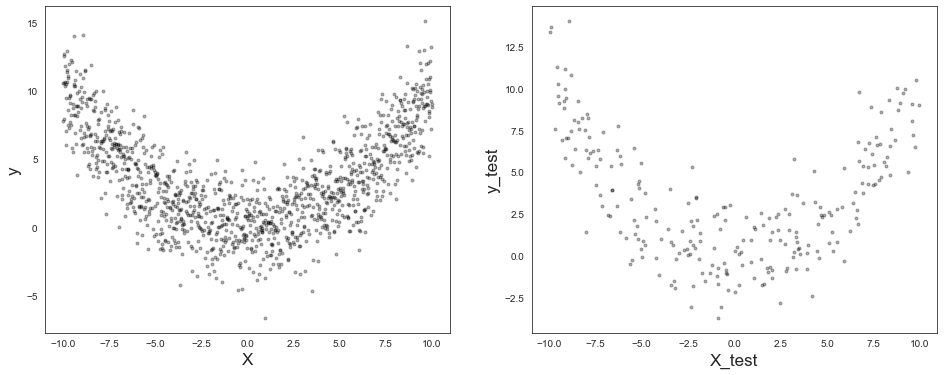

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1554.22draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.100544,0.000918,0.000020,0.098738,0.102307,1802.408619,1.000257
b,-0.003146,0.004857,0.000086,-0.011969,0.006719,3067.913253,0.999572
c,0.065309,0.041617,0.000979,-0.019529,0.140438,1673.568844,1.000283


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-5.236825,4.344910,0.940333,0.796
1,4.969980,1.283633,0.115333,0.256
2,-0.153436,0.795011,0.776000,0.652
3,0.713809,-0.181396,0.383333,0.428
4,-0.033356,1.222372,0.883667,0.724


[6.25000000e-04 5.05333333e-01 9.98785714e-01]


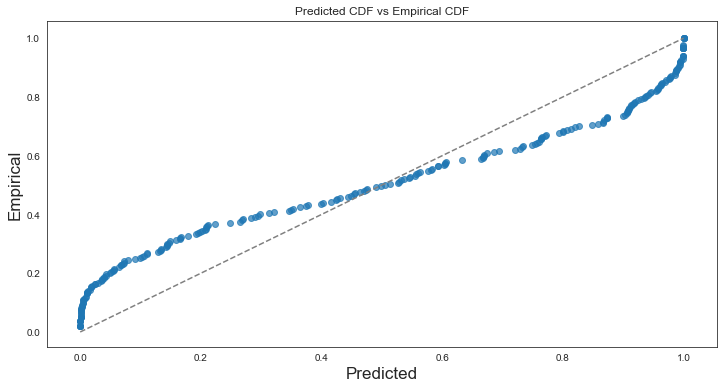

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

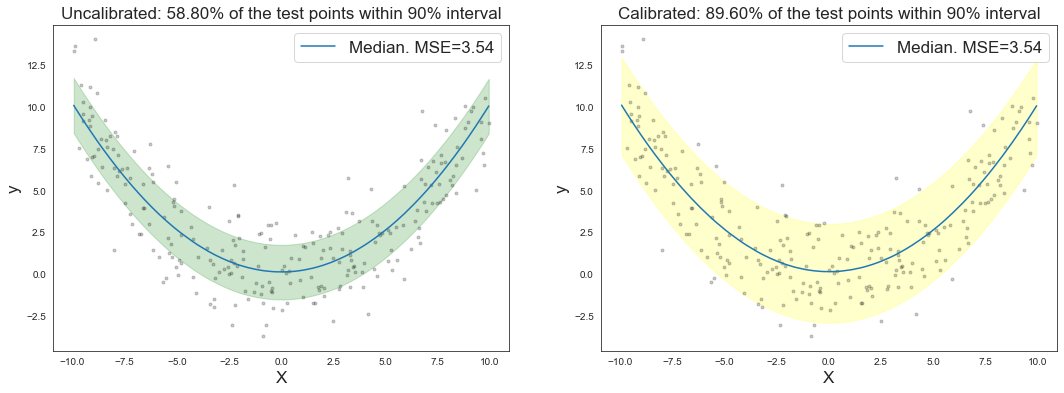

In [7]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
_, cal_quants, unc_quants = calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

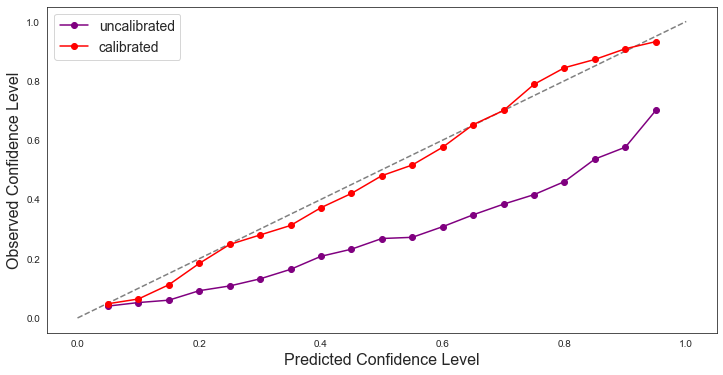

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

# Epistemic uncertainty

**1. Missing data in certain regions of input space**

In [191]:
f = lambda x: np.sin(0.05*x**2) + 4 + np.random.normal(0, 0.4, size=len(x))
#np.sin(0.05*x**2) + 4 + np.random.normal(0, 0.4, size=len(x))
#0.1*x**2 + np.random.normal(0, 2, size=len(x))
X = np.concatenate([np.linspace(-10, -5, 10),
                    np.linspace(-5, 5, 500),
                    np.linspace(5, 10, 10)
                    #np.linspace(-8, -6, 100),
                    #np.linspace(-1, 1, 100),
                    #np.linspace(6, 8, 100)
                  ])
# X = np.linspace(-10, 10, 400)
y = f(X)
# X = X[(y > 3.5) & (y < 4.5)]
# y = y[(y > 3.5) & (y < 4.5)]

# X = np.concatenate([np.linspace(-10, 0, 500),
#                     #np.linspace(-8, -6, 100),
#                     #np.linspace(-1, 1, 100),
#                     np.linspace(0, 10, 7)
#                    ])
# y = f(X)

X_test = np.linspace(-10, 10, 200)
y_test = f(X_test)

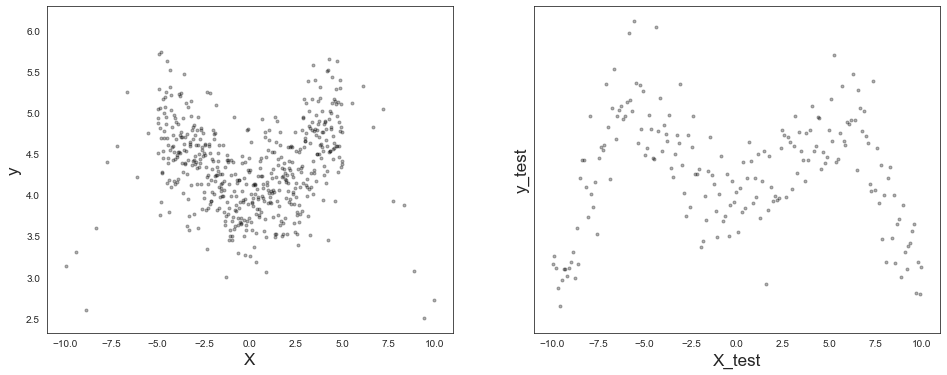

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True, sharey=True)

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

$$
\begin{aligned}
f(x) &= a x^2 + b x + c \\
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\end{aligned}
$$

Finally, we get: 

$$
y \sim \mathcal{N}(\mu,\sigma), \quad \mu = f(x), \sigma=1
$$

In [193]:
with pm.Model() as model:
#     a = pm.Normal('a', mu=0, sigma=1) 
#     b = pm.Normal('b', mu=0, sigma=1) 
#     c = pm.Normal('c', mu=0, sigma=1) 
#     d = pm.Normal('d', mu=0, sigma=1) 
#     e = pm.Normal('e', mu=0, sigma=1) 
    
#     f_x = e*pm.math.sin(d*pm.math.cos(X) + a*X**2) + b*X + c
#     y_obs = pm.Normal('y', mu=f_x, sigma=0.4, observed=y)
    
#     trace = pm.sample(1000, tune=1000)

    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=0.4, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2338.32draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.005070,0.001370,0.000028,0.002440,0.007747,2681.871198,0.999774
b,0.000488,0.005445,0.000090,-0.010004,0.010922,3638.528795,0.999555
c,4.290772,0.022812,0.000456,4.245293,4.334257,2365.807308,0.999553


In [194]:
# def posterior_predictive(x, e, d, a, b, c, sigma=1):
#     x, e, d, a, b, c = x.reshape(-1,1), e.reshape(-1,1), d.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
#     noise = np.random.normal(scale=sigma, size=a.shape[0])
#     samples = np.sin(np.cos(x).dot(d.T) + (x**2).dot(a.T))*(e.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
#     return samples

def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [195]:
# e, d, a, b, c = trace['e'][:-1000], trace['d'][:-1000], trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
# pp_params = {'e':e, 'd':d, 'a': a, 'b': b, 'c': c}

a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]
pp_params = {'a': a, 'b': b, 'c': c}

calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,3.236473,4.633581,0.620667,0.750000
1,-0.130261,4.305951,0.507000,0.528846
2,-0.070140,4.446907,0.570333,0.644231
3,3.096192,4.099265,0.396333,0.336538
4,3.617234,4.503616,0.563333,0.625000


[0.21006667 0.515      0.78086667]


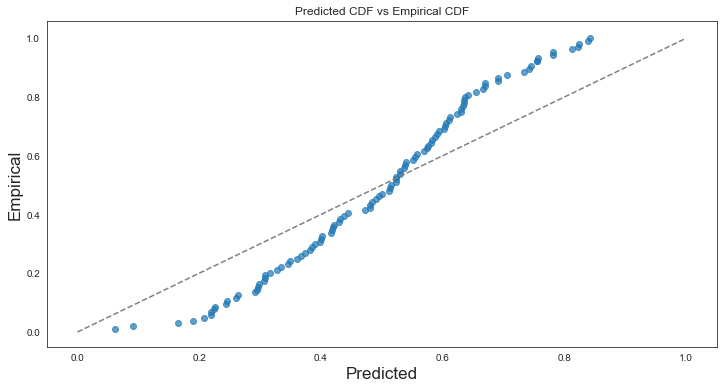

In [196]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

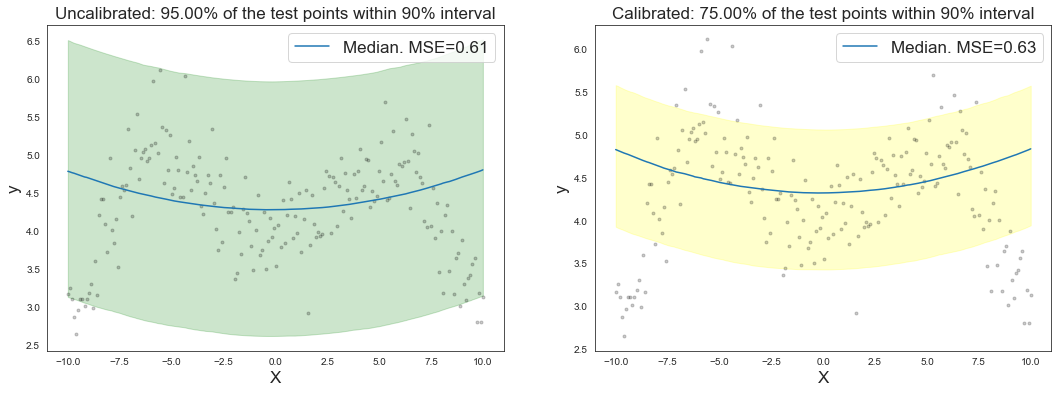

In [197]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
_, cal_quants, unc_quants = calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

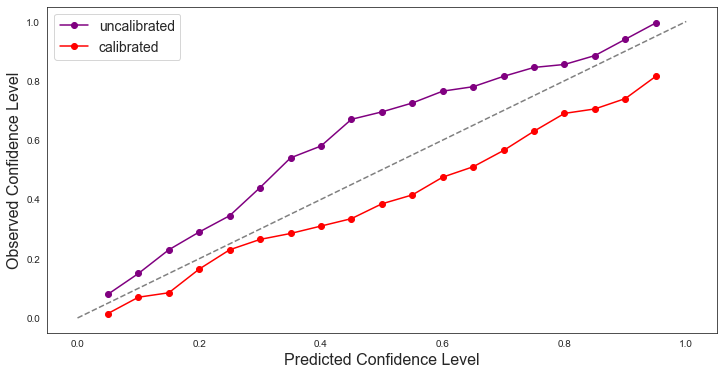

In [198]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

**2. Measurement tools are bad**

In [199]:
f = lambda x: np.sin(0.05*x**2) + 4 + np.random.normal(0, 0.4, size=len(x))
#np.sin(0.05*x**2) + 4 + np.random.normal(0, 0.4, size=len(x))
#0.1*x**2 + np.random.normal(0, 2, size=len(x))
# X = np.concatenate([np.linspace(-10, -5, 10),
#                     np.linspace(-5, 5, 500),
#                     np.linspace(5, 10, 10)
#                     #np.linspace(-8, -6, 100),
#                     #np.linspace(-1, 1, 100),
#                     #np.linspace(6, 8, 100)
#                   ])
X = np.linspace(-10, 10, 400)
y = f(X)
X = X[(y > 3.5) & (y < 4.5)]
y = y[(y > 3.5) & (y < 4.5)]

# X = np.concatenate([np.linspace(-10, 0, 500),
#                     #np.linspace(-8, -6, 100),
#                     #np.linspace(-1, 1, 100),
#                     np.linspace(0, 10, 7)
#                    ])
# y = f(X)

X_test = np.linspace(-10, 10, 200)
y_test = f(X_test)

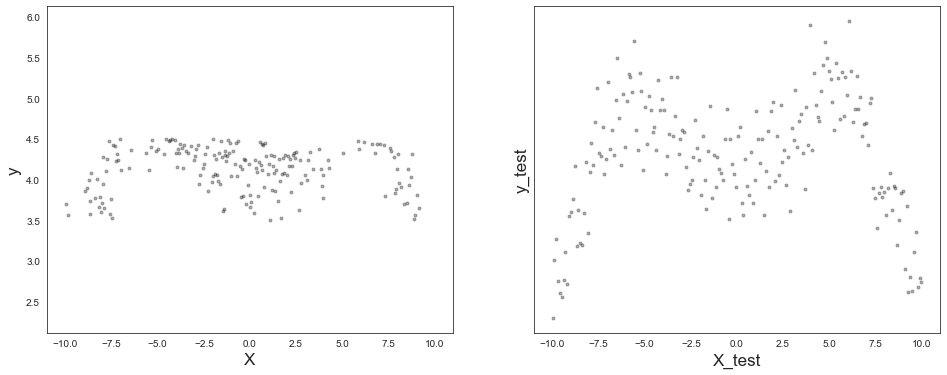

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True, sharey=True)

ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

In [201]:
with pm.Model() as model:
#     a = pm.Normal('a', mu=0, sigma=1) 
#     b = pm.Normal('b', mu=0, sigma=1) 
#     c = pm.Normal('c', mu=0, sigma=1) 
#     d = pm.Normal('d', mu=0, sigma=1) 
#     e = pm.Normal('e', mu=0, sigma=1) 
    
#     f_x = e*pm.math.sin(d*pm.math.cos(X) + a*X**2) + b*X + c
#     y_obs = pm.Normal('y', mu=f_x, sigma=0.4, observed=y)
    
#     trace = pm.sample(1000, tune=1000)

    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=0.4, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:03<00:00, 2221.11draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.002674,0.001025,0.000024,-0.004603,-0.000647,2250.960699,0.999503
b,-0.000881,0.005921,0.000094,-0.012884,0.010649,3512.057773,1.000736
c,4.186943,0.037277,0.000788,4.110645,4.255768,2540.817996,0.999539


In [202]:
# e, d, a, b, c = trace['e'][:-1000], trace['d'][:-1000], trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
# pp_params = {'e':e, 'd':d, 'a': a, 'b': b, 'c': c}

a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]
pp_params = {'a': a, 'b': b, 'c': c}

calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-0.275689,4.242536,0.513667,0.564103
1,-8.847118,3.892044,0.463333,0.333333
2,-1.528822,4.280980,0.528333,0.666667
3,-0.375940,3.795867,0.361333,0.076923
4,-8.145363,3.792023,0.413667,0.205128


[0.30048333 0.50016667 0.62365   ]


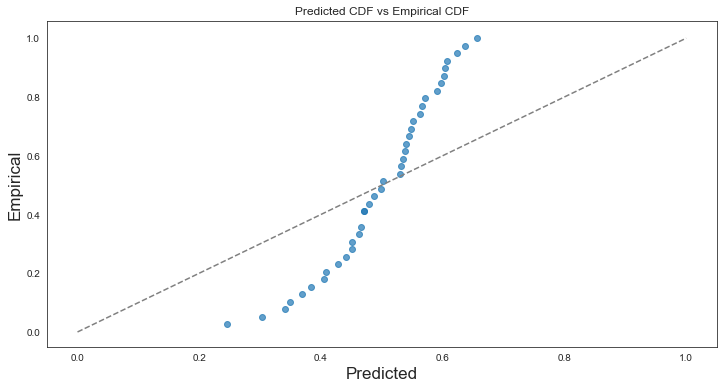

In [203]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

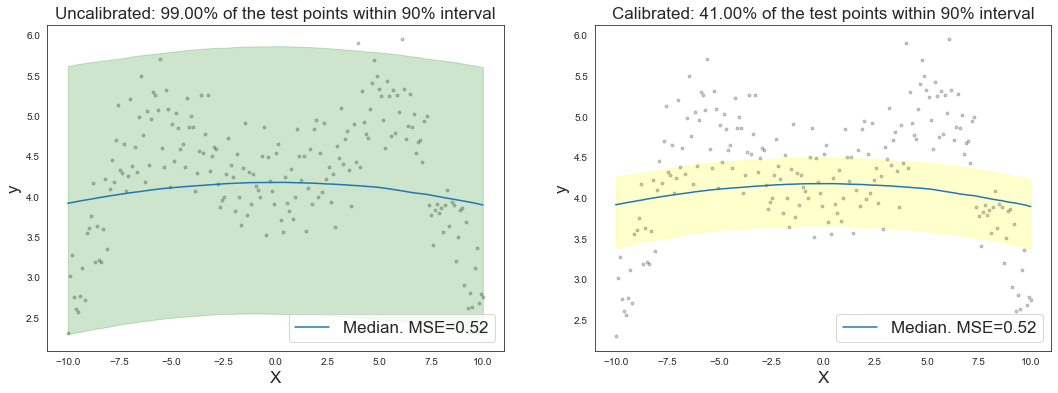

In [204]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
_, cal_quants, unc_quants = calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

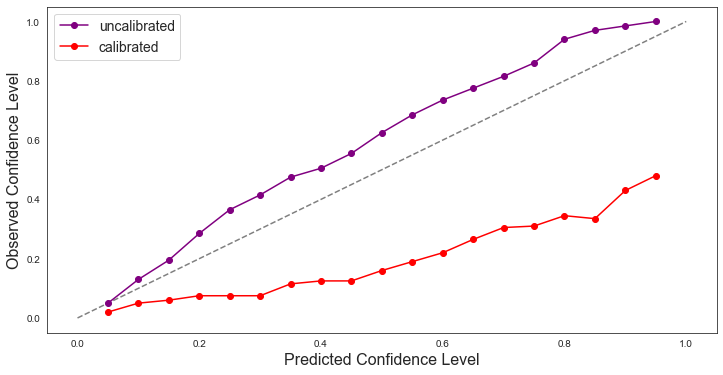

In [205]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);